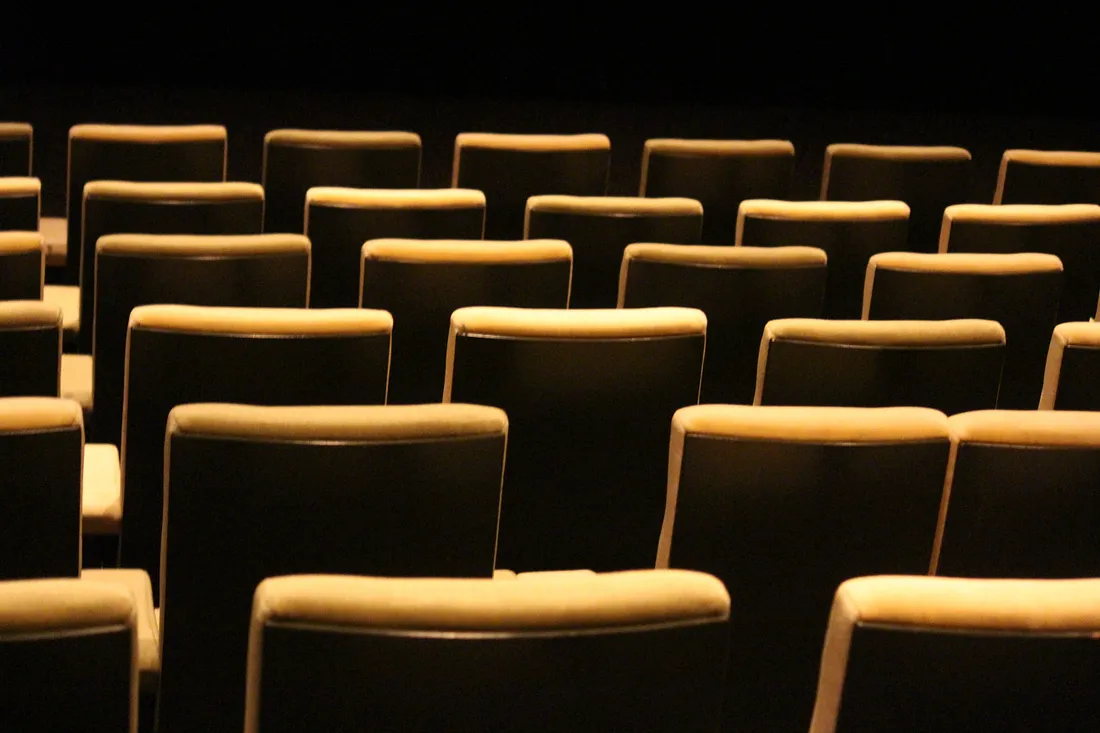

Sentiment Analysis is a common NLP task that Data Scientists need to perform. This is a straightforward guide to creating a barebones movie review classifier in Python. Future parts of this series will focus on improving the classifier.

Data Overview
For this analysis we’ll be using a dataset of 50,000 movie reviews taken from IMDb.

The data is split evenly with 25k reviews intended for training and 25k for testing your classifier. Moreover, each set has 12.5k positive and 12.5k negative reviews.

IMDb lets users rate movies on a scale from 1 to 10. To label these reviews the curator of the data labeled anything with ≤ 4 stars as negative and anything with ≥ 7 stars as positive. Reviews with 5 or 6 stars were left out.

In [1]:
reviews_train = []
for line in open('./data/full_train.txt', 'r', encoding="utf8"):
    reviews_train.append(line.strip())
    
reviews_test = []
for line in open('./data/full_test.txt', 'r', encoding="utf8"):
    reviews_test.append(line.strip())

Note: Understanding and being able to use regular expressions is a prerequisite for doing any Natural Language Processing task. 

In [2]:
import re

REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

def preprocess_reviews(reviews):
    reviews = [REPLACE_NO_SPACE.sub("", line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(" ", line) for line in reviews]
    
    return reviews

reviews_train_clean = preprocess_reviews(reviews_train)
reviews_test_clean = preprocess_reviews(reviews_test)

And this is what the same review looks like now:

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(binary=True)
cv.fit(reviews_train_clean)
X = cv.transform(reviews_train_clean)
X_test = cv.transform(reviews_test_clean)

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

target = [1 if i < 12500 else 0 for i in range(25000)]

X_train, X_val, y_train, y_val = train_test_split(
    X, target, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=1000)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))
    
#     Accuracy for C=0.01: 0.87472
#     Accuracy for C=0.05: 0.88368
#     Accuracy for C=0.25: 0.88016
#     Accuracy for C=0.5: 0.87808
#     Accuracy for C=1: 0.87648

Accuracy for C=0.01: 0.86976
Accuracy for C=0.05: 0.87728
Accuracy for C=0.25: 0.87808
Accuracy for C=0.5: 0.87648
Accuracy for C=1: 0.87504


It looks like the value of C that gives us the highest accuracy is 0.05.

## Train Final Model
Now that we’ve found the optimal value for C, we should train a model using the entire training set and evaluate our accuracy on the 25k test reviews.

In [5]:
final_model = LogisticRegression(C=0.05, solver='lbfgs', max_iter=1000)
final_model.fit(X, target)
print ("Final Accuracy: %s" 
       % accuracy_score(target, final_model.predict(X_test)))
# Final Accuracy: 0.88128

Final Accuracy: 0.88156


As a sanity check, let’s look at the 5 most discriminating words for both positive and negative reviews. We’ll do this by looking at the largest and smallest coefficients, respectively.

In [6]:
feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names_out(), final_model.coef_[0]
    )
}
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print (best_positive)
    
#     ('excellent', 0.9288812418118644)
#     ('perfect', 0.7934641227980576)
#     ('great', 0.675040909917553)
#     ('amazing', 0.6160398142631545)
#     ('superb', 0.6063967799425831)
    
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print (best_negative)
    
#     ('worst', -1.367978497228895)
#     ('waste', -1.1684451288279047)
#     ('awful', -1.0277001734353677)
#     ('poorly', -0.8748317895742782)
#     ('boring', -0.8587249740682945)

('excellent', 0.9287972580642614)
('perfect', 0.7916720051806639)
('great', 0.674056645967301)
('amazing', 0.613182651568618)
('superb', 0.6011369199241123)
('worst', -1.3647113537043942)
('waste', -1.166858301194453)
('awful', -1.0320826529832108)
('poorly', -0.8752032388463086)
('boring', -0.8567748851705197)


And there it is. A very simple classifier with pretty decent accuracy out of the box.

**Removing Stop Words**
Stop words are the very common words like ‘if’, ‘but’, ‘we’, ‘he’, ‘she’, and ‘they’. We can usually remove these words without changing the semantics of a text and doing so often (but not always) improves the performance of a model. Removing these stop words becomes a lot more useful when we start using longer word sequences as model features (see n-grams below).

In [7]:
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords

english_stop_words = stopwords.words('english')
def remove_stop_words(corpus):
    removed_stop_words = []
    for review in corpus:
        removed_stop_words.append(
            ' '.join([word for word in review.split() 
                      if word not in english_stop_words])
        )
    return removed_stop_words

no_stop_words = remove_stop_words(reviews_train_clean)

[nltk_data] Downloading package wordnet to C:\Users\Mayank
[nltk_data]     Monani\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
def get_stemmed_text(corpus):
    from nltk.stem.porter import PorterStemmer
    stemmer = PorterStemmer()
    return [' '.join([stemmer.stem(word) for word in review.split()]) for review in corpus]

stemmed_reviews = get_stemmed_text(reviews_train_clean)

**Lemmatization**

Lemmatization works by identifying the part-of-speech of a given word and then applying more complex rules to transform the word into its true root.

In [9]:
def get_lemmatized_text(corpus):
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    return [' '.join([lemmatizer.lemmatize(word) for word in review.split()]) for review in corpus]

lemmatized_reviews = get_lemmatized_text(reviews_train_clean)


In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 2))
ngram_vectorizer.fit(reviews_train_clean)
X = ngram_vectorizer.transform(reviews_train_clean)
X_test = ngram_vectorizer.transform(reviews_test_clean)

X_train, X_val, y_train, y_val = train_test_split(
    X, target, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=1000)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))
    
# Accuracy for C=0.01: 0.88416
# Accuracy for C=0.05: 0.892
# Accuracy for C=0.25: 0.89424
# Accuracy for C=0.5: 0.89456
# Accuracy for C=1: 0.8944
    
final_ngram = LogisticRegression(C=0.5, solver='lbfgs', max_iter=1000)
final_ngram.fit(X, target)
print ("Final Accuracy: %s" 
       % accuracy_score(target, final_ngram.predict(X_test)))

# Final Accuracy: 0.898

Accuracy for C=0.01: 0.88384
Accuracy for C=0.05: 0.89056
Accuracy for C=0.25: 0.8912
Accuracy for C=0.5: 0.892
Accuracy for C=1: 0.89152
Final Accuracy: 0.89776


Getting pretty close to 90%! So, simply considering 2-word sequences in addition to single words increased our accuracy by more than 1.6 percentage points.



In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

wc_vectorizer = CountVectorizer(binary=False)
wc_vectorizer.fit(reviews_train_clean)
X = wc_vectorizer.transform(reviews_train_clean)
X_test = wc_vectorizer.transform(reviews_test_clean)

X_train, X_val, y_train, y_val = train_test_split(
    X, target, train_size = 0.75, 
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=1000)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))
    
# Accuracy for C=0.01: 0.87456
# Accuracy for C=0.05: 0.88016
# Accuracy for C=0.25: 0.87936
# Accuracy for C=0.5: 0.87936
# Accuracy for C=1: 0.87696
    
final_wc = LogisticRegression(C=0.05, solver='lbfgs', max_iter=1000)
final_wc.fit(X, target)
print ("Final Accuracy: %s" 
       % accuracy_score(target, final_wc.predict(X_test)))

# Final Accuracy: 0.88184

Accuracy for C=0.01: 0.87152
Accuracy for C=0.05: 0.88096
Accuracy for C=0.25: 0.88144
Accuracy for C=0.5: 0.87792
Accuracy for C=1: 0.87584
Final Accuracy: 0.8822


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(reviews_train_clean)
X = tfidf_vectorizer.transform(reviews_train_clean)
X_test = tfidf_vectorizer.transform(reviews_test_clean)

X_train, X_val, y_train, y_val = train_test_split(
    X, target, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=1000)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))

# Accuracy for C=0.01: 0.79632
# Accuracy for C=0.05: 0.83168
# Accuracy for C=0.25: 0.86768
# Accuracy for C=0.5: 0.8736
# Accuracy for C=1: 0.88432
    
final_tfidf = LogisticRegression(C=1, solver='lbfgs', max_iter=1000)
final_tfidf.fit(X, target)
print ("Final Accuracy: %s" 
       % accuracy_score(target, final_tfidf.predict(X_test)))

# Final Accuracy: 0.882

Accuracy for C=0.01: 0.80128
Accuracy for C=0.05: 0.83568
Accuracy for C=0.25: 0.8744
Accuracy for C=0.5: 0.88624
Accuracy for C=1: 0.89328
Final Accuracy: 0.8824


In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 2))
ngram_vectorizer.fit(reviews_train_clean)
X = ngram_vectorizer.transform(reviews_train_clean)
X_test = ngram_vectorizer.transform(reviews_test_clean)

X_train, X_val, y_train, y_val = train_test_split(
    X, target, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    svm = LinearSVC(C=c, max_iter=1500)
    svm.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, svm.predict(X_val))))
    
# Accuracy for C=0.01: 0.89104
# Accuracy for C=0.05: 0.88736
# Accuracy for C=0.25: 0.8856
# Accuracy for C=0.5: 0.88608
# Accuracy for C=1: 0.88592
    
final_svm_ngram = LinearSVC(C=0.01, max_iter=1500)
final_svm_ngram.fit(X, target)
print ("Final Accuracy: %s" 
       % accuracy_score(target, final_svm_ngram.predict(X_test)))

# Final Accuracy: 0.8974

Accuracy for C=0.01: 0.8944
Accuracy for C=0.05: 0.8904
Accuracy for C=0.25: 0.88896
Accuracy for C=0.5: 0.8888


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy for C=1: 0.8888
Final Accuracy: 0.89708


In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC


stop_words = ['in', 'of', 'at', 'a', 'the']
ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 3), stop_words=stop_words)
ngram_vectorizer.fit(reviews_train_clean)
X = ngram_vectorizer.transform(reviews_train_clean)
X_test = ngram_vectorizer.transform(reviews_test_clean)

X_train, X_val, y_train, y_val = train_test_split(
    X, target, train_size = 0.75
)

for c in [0.001, 0.005, 0.01, 0.05, 0.1]:
    
    svm = LinearSVC(C=c, max_iter=1000)
    svm.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, svm.predict(X_val))))
    
# Accuracy for C=0.001: 0.88784
# Accuracy for C=0.005: 0.89456
# Accuracy for C=0.01: 0.89376
# Accuracy for C=0.05: 0.89264
# Accuracy for C=0.1: 0.8928
    
final = LinearSVC(C=0.01, max_iter=1000)
final.fit(X, target)
print ("Final Accuracy: %s" 
       % accuracy_score(target, final.predict(X_test)))

# Final Accuracy: 0.90064


Accuracy for C=0.001: 0.87904
Accuracy for C=0.005: 0.8872
Accuracy for C=0.01: 0.89104
Accuracy for C=0.05: 0.89088
Accuracy for C=0.1: 0.8912
Final Accuracy: 0.90024


We broke the 90% mark!

**Summary**
We’ve gone over several options for transforming text that can improve the accuracy of an NLP model. Which combination of these techniques will yield the best results will depend on the task, data representation, and algorithms you choose. It’s always a good idea to try out many different combinations to see what works.